# Project 4: West Nile Virus - Modelling

---
# Table of Contents

- Import Libraries and Data
- Preprocessing
- Modelling
- Evaluating and Interpreting Results
- Generating Predictions for Kaggle
- Conclusion
---
7 different models are tested & evaluated and the metric used for scoring is ROC-AUC.

# Import Libraries and Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay

In [2]:
# import training dataset
train = pd.read_csv('../output_data/merged_train.csv')

# data cleaning
train.set_index('date', inplace=True)

# check the df columns
print(f'Features in training set : {train.columns.tolist()}')

Features in training set : ['species', 'latitude', 'longitude', 'wnvpresent', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight', 'relative_hum', 'tavg_weekly', 'relative_hum_weekly', 'preciptotal_weekly', 'tavg_weekly_lag1', 'tavg_weekly_lag2', 'relative_hum_weekly_lag1', 'relative_hum_weekly_lag2', 'preciptotal_weekly_lag1', 'preciptotal_weekly_lag2']


In [3]:
# define feature matrix and target vector
X = train.drop(columns='wnvpresent')
y = train['wnvpresent']

# Preprocessing 
## Train-validation  split

The data is split into train & validation sets. Stratify = y was used because they generate better prediction results.

In [4]:
# split dataset into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  random_state=42,
                                                  stratify=y)

In [5]:
# check the shape of training and testing vectors
print(" Train Set Shape ".center(27, '='))
print(f'Features X_train: {X_train.shape}')
print(f'Targets y_train:  {y_train.shape}')
print()
print(" Validation Set Shape ".center(26, '='))
print(f'Features X_val:   {X_val.shape}')
print(f'Targets y_val:    {y_val.shape}')

===== Train Set Shape =====
Features X_train: (7879, 24)
Targets y_train:  (7879,)

== Validation Set Shape ==
Features X_val:   (2627, 24)
Targets y_val:    (2627,)


## Features transformation 

One Hot Encoder was used for categorical features such as Mosquito Species, as explained on the EDA/ Feature Engineering notebook. Numerical features are transformed using StandardScaler to ensure that they have the same range, which is important for certain classifiers like Logistic Regression.

In [6]:
# instantiate transformers 
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
sc = StandardScaler()


# instantiate transformers into column transformer 
ct = make_column_transformer(
    (sc, make_column_selector(dtype_include='number')),
    (ohe, make_column_selector(dtype_exclude='number')),
    remainder='passthrough', 
    verbose_feature_names_out=False
)

# transform feature matrix
X_train = pd.DataFrame(ct.fit_transform(X_train), 
                       columns=ct.get_feature_names_out())

X_val = pd.DataFrame(ct.transform(X_val), 
                       columns=ct.get_feature_names_out())

# check X matrix after transformation
X_train.head()

,latitude,longitude,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,relative_hum_weekly_lag2,preciptotal_weekly_lag1,preciptotal_weekly_lag2,species_ERRATICUS,species_PIPIENS,species_PIPIENS/RESTUANS,species_RESTUANS,species_SALINARIUS,species_TARSALIS,species_TERRITANS
0,0.627512,-0.279292,0.074525,-0.149319,-0.065976,0.660970,-0.148577,-0.118680,-0.330573,-0.241910,...,0.890670,-0.718824,-0.185112,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.351569,-0.658353,-1.856803,-2.343141,-2.202696,-1.646831,-2.182258,-2.268127,2.814834,-1.549664,...,0.890670,-0.718824,-0.185112,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.185404,-1.972897,-2.822467,-2.210182,-2.670104,-2.262245,-2.627126,-2.638722,4.110001,-1.549664,...,0.890670,-0.718824,-0.185112,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.035515,-2.390206,-0.408307,-0.016360,-0.266293,-0.877564,-1.610285,-1.008107,-0.330573,-0.503461,...,-1.930212,-0.103824,-1.033891,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.185404,-1.972897,-1.675741,-1.412429,-1.668516,-1.339124,-1.928048,-1.897533,1.334643,-1.549664,...,0.222000,-0.799921,0.096492,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
# check the df cloumns
print(f'Features in X matrix: {X_train.columns.tolist()}')

Features in X matrix: ['latitude', 'longitude', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight', 'relative_hum', 'tavg_weekly', 'relative_hum_weekly', 'preciptotal_weekly', 'tavg_weekly_lag1', 'tavg_weekly_lag2', 'relative_hum_weekly_lag1', 'relative_hum_weekly_lag2', 'preciptotal_weekly_lag1', 'preciptotal_weekly_lag2', 'species_ERRATICUS', 'species_PIPIENS', 'species_PIPIENS/RESTUANS', 'species_RESTUANS', 'species_SALINARIUS', 'species_TARSALIS', 'species_TERRITANS']


In [8]:
# check the shape of training and testing vectors
print(" Train Set Shape ".center(27, '='))
print(f'Features X_train: {X_train.shape}')
print(f'Targets y_train:  {y_train.shape}')
print()
print(" Validation Set Shape ".center(26, '='))
print(f'Features X_val:   {X_val.shape}')
print(f'Targets y_val:    {y_val.shape}')

===== Train Set Shape =====
Features X_train: (7879, 30)
Targets y_train:  (7879,)

== Validation Set Shape ==
Features X_val:   (2627, 30)
Targets y_val:    (2627,)


We confirm that the train & validation set shapes are similar and proceed to the modelling section.

# Modelling


In this section, we define a modelling and scoring function, as well as run the following models:

- Dummy Classifier
- Random Forest Classifier
- Support Vector Classifier
- Logistic Regression
- K Nearest Neighbors
- Gradient Boosting Classifier
- XGBoost Classifier
- Extra Trees Classifier

## Functions used

Two functions are defined here. Fit_gs fits a GridSearchCV to a classifier, prints best parameters and returns model. Eval_model returns a dataframe of scoring & evaluation metrics.

In [9]:
def fit_gs(clf, params):
    """fits a GridSearchCV to a classifier, prints best params and returns model"""
    
    gs = GridSearchCV(clf, params, cv=5, n_jobs=-1, scoring= "roc_auc")
    gs.fit(X_train, y_train)
    
    print(f"Best Parameters: {gs.best_params_}")
    
    return gs

In [10]:
def eval_model(model):
    """returns dataframe of evaluation metrics for classifier"""
    
    # get predictions
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1]
        
    # metrics for evaluating classifier
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    
    accuracy = (tn + tp) / (tn + fp + fn + tp)
    
    if (tn + fp) != 0:
        spec = tn / (tn + fp)
    else:
        spec = 'NA'
        
    if (tp + fn) != 0:
        recall = tp / (tp + fn)
    else:
        recall = np.nan

    if (tp + fp) != 0:
        precision = tp / (tp + fp)
    else:
        precision = np.nan
        
    if recall == np.nan or precision == np.nan:
        f1 = np.nan
    else:
        f1 = 2*((precision*recall)/(precision+recall))

    roc = roc_auc_score(y_val, y_proba)
    
    try:
        model_name = str(model.estimator)[:-2]
        if len(model_name) > 30:
            model_name = model_name[:13]
    except:
        model_name = 'Dummy'
        
    df = pd.DataFrame([np.round([accuracy, spec, recall, precision, f1, fp, fn, roc], 3)], 
                      columns = ["Accuracy", 
                                 "Specificity", 
                                 "Recall", 
                                 "Precision", 
                                 "F1", 
                                 "False Positives", 
                                 "False Negatives", 
                                 "ROC-AUC"], 
                      index = [model_name],
                      dtype='str')
    return df

## (0) Dummy Model

The dummy model is used as the baseline model, which is the simplest possible prediction of a model. Because this is an imbalanced classification problem with majority of the data being 0, the dummy classifier produces a high specificity (1.0) with a 0 recall (0.0) and a ROC-AUC of 0.5, which will be used as the baseline for comparison with relatively more complex models.

In [11]:
# fit dummy model
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

dummy_result = eval_model(dummy)
dummy_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
Dummy,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.5


## (1) Random Forest Classifier

Random Forest has its advantages in this classification problem because it is non-parameteric and makes no underlying assumptions of the data distribution. However, it has a tendency to overfit onto training & validation data and underperform on the test set (the Kaggle dataset).

The best parameters of class weight 0:1 and 1:10 are unsurprising because of the imbalance in class. Max_depth and n_estimators are the most important parameters of this classifier.

In [12]:
rfc_params = {"n_estimators": [10, 50, 100, 250], 
              "max_depth": [5, 10, 20],
              "class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}],
              "random_state": [42]
             }
rfc = fit_gs(RandomForestClassifier(), rfc_params)

Best Parameters: {'class_weight': {0: 1, 1: 5}, 'max_depth': 5, 'n_estimators': 250, 'random_state': 42}


In [13]:
rfc_result = eval_model(rfc)
rfc_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
RandomForestClassifier,0.935,0.979,0.138,0.268,0.182,52.0,119.0,0.807


## (2) Support Vector Classifier

SVC has one of the lowest performing model accuracy but its ROC-AUC score is decent and comparable to other models. It talso has the lowest false negative rate, which is beneficial because false negatives are more dangerous than false positives in this problem set. It is worse to leave a WNV-positive mosquito undetected than to falsely predict a WNV-negative mosquito as WNV-positive.

In [14]:
svc_params = {"C": [10**-2, 10**-1, 10**0, 10**1, 10**2],
              "class_weight": [None, {0:1,1:10}, {0:1,1:25}],
              "probability": [True],
              "random_state": [42]
             }
svc = fit_gs(SVC(), svc_params)

Best Parameters: {'C': 1, 'class_weight': {0: 1, 1: 10}, 'probability': True, 'random_state': 42}


In [15]:
svc_result = eval_model(svc)
svc_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
SVC,0.809,0.818,0.63,0.161,0.257,452.0,51.0,0.815


## (3) Logistic Regression

The best penalty is L1 (Lasso) rather than L2 (Ridge), which implies that some features are given a weight of 0 during the modelling process. The C of 1 suggests a moderate level of regularization.

The benefit of using Logistic Regression is the interpretability of coefficients. However, because its false negative rate is too high, it yields little benefit to our classification task.

In [16]:
lr_params = {"C": [10**-2, 10**-1, 10**0, 10**1, 10**2],
             "penalty": ['l1', 'l2'],
             "max_iter": [20, 50, 100, 200],
             "class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}],
             "solver": ['liblinear'],
             "random_state": [42]
            }

lr = fit_gs(LogisticRegression(), lr_params)

Best Parameters: {'C': 100, 'class_weight': None, 'max_iter': 20, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear'}


In [17]:
lr_result = eval_model(lr)
lr_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
LogisticRegression,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.769


## (4) K-nearest neighbours

K Nearest Neighbors produced very similar results to Logistic Regression.

In [18]:
knn_params = {"n_neighbors": [5,35,65,95]}

knn = fit_gs(KNeighborsClassifier(), knn_params)

Best Parameters: {'n_neighbors': 65}


In [19]:
knn_result = eval_model(knn)
knn_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
KNeighborsClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.793


## (5) Gradient boosting classifier

Gradient Boosting Classifier has the highest ROC-AUC score among all the models and will be selected as the production model.

In [20]:
gbc_params = {"n_estimators": [150, 200, 250],
              "max_depth": [3, 5],
              "random_state": [42]
             }
gbc = fit_gs(GradientBoostingClassifier(), gbc_params)

Best Parameters: {'max_depth': 3, 'n_estimators': 200, 'random_state': 42}


In [21]:
gbc_result = eval_model(gbc)
gbc_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
GradientBoostingClassifier,0.944,0.992,0.08,0.367,0.131,19.0,127.0,0.826


## (6) XGB classifier

XGB classifier is widely regarded as the best performing classifier. However, it has a very high computational cost. Disappointingly, it did not yield better ROC-AUC scores than Gradient Boost Classifier, although it had the best accuracy score among all of the models.

In [22]:
xgb_params = {"use_label_encoder": [False],
              "objective": ["binary:logistic"],
              "eval_metric": ['auc'],
              "learning_rate":[0.1, 0.2, 0.5],
              "max_depth": [5,8],
              "max_leaf_nodes": [None,], #tune params
              "gamma": np.linspace(5, 100, 8),
              "reg_alpha": np.linspace(0.0001, 1, 8),
              "reg_lambda": np.linspace(5, 100, 5)} #tune params

xgb = fit_gs(XGBClassifier(random_state = 42), xgb_params)

Best Parameters: {'eval_metric': 'auc', 'gamma': 5.0, 'learning_rate': 0.5, 'max_depth': 8, 'max_leaf_nodes': None, 'objective': 'binary:logistic', 'reg_alpha': 0.0001, 'reg_lambda': 5.0, 'use_label_encoder': False}


In [23]:
xgb_result = eval_model(xgb)
xgb_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
XGBClassifier,0.946,0.996,0.029,0.308,0.053,9.0,134.0,0.813


## (7) Extra trees classifier

Extra trees yielded one of the most impressive accuracy scores but with an ROC-AUC comparable to the other models. These results strongly suggest overfitting.

In [24]:
et_params = {"max_depth": [3,5,10,20],
             "min_samples_leaf": [1, 3, 10, 20],
             "max_leaf_nodes": [None, 5, 10],
             "random_state": [42]
            }
et = fit_gs(ExtraTreesClassifier(), et_params)

Best Parameters: {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'random_state': 42}


In [25]:
et_result = eval_model(et)
et_result

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
ExtraTreesClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.814


# Evaluating and Interpreting Results
## Summary of results for all models

In [26]:
summary = pd.concat([dummy_result, rfc_result, svc_result, lr_result, knn_result, gbc_result, xgb_result, 
                    et_result]) 
summary

,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
Dummy,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.5
RandomForestClassifier,0.935,0.979,0.138,0.268,0.182,52.0,119.0,0.807
SVC,0.809,0.818,0.63,0.161,0.257,452.0,51.0,0.815
LogisticRegression,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.769
KNeighborsClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.793
GradientBoostingClassifier,0.944,0.992,0.08,0.367,0.131,19.0,127.0,0.826
XGBClassifier,0.946,0.996,0.029,0.308,0.053,9.0,134.0,0.813
ExtraTreesClassifier,0.947,1.0,0.0,NaN,NaN,0.0,138.0,0.814


Dummy, Extra Trees, K Nearest Neighbors and Logistic regression produced very similar results, which makes accuracy an unsuitable metric for evaluation - just by predicting all instances as negative (absence of WNV), one will get the highest accuracy rate).

Instead, the following metrics will be used for evaluation:
- ROC-AUC
- False negatives

False negatives: The classifier with the lowest false negative rate was SVC. SVC also had the 2nd highest ROC-AUC scores.

ROC-AUC: Gradient Boosting Classifier outperformed all the other models and will be used as the final model for production.

## ROC plot

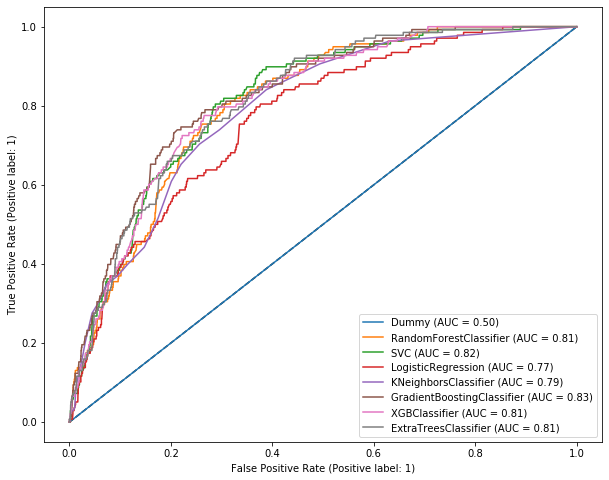

In [27]:
models = [dummy, rfc, svc, lr, knn, gbc, xgb, et]

fig, ax = plt.subplots(figsize=(10,8))
plt.plot([0, 1], [0, 1], "k--")
for i, model in enumerate(models):
    RocCurveDisplay.from_estimator(model,
                                   X_val,
                                   y_val,
                                   ax=ax,
                                   name=f'{summary.index[i]}')

From the graph, it can be observed that the Gradient Boosting Classifier outperforms almost every other model in terms of ROC-AUC. The SVC is the 2nd best, but its accuracy score is very compromised.

## Important features

In [28]:
def get_impt_features(models):
    result = pd.DataFrame()
    for i, model in enumerate(models):
        try:
            importances = model.best_estimator_.feature_importances_
            df = pd.DataFrame(zip(X_train.columns,importances), 
                              columns=[f'{summary.index[i]}','importance']).\
                sort_values('importance', ascending=False).reset_index(drop=True)
            result = pd.concat([result,df], axis = 1)
            
        except:
            pass
        
        try:
            coef = model.best_estimator_.coef_
            df = pd.DataFrame([X_train.columns,(*coef)]).T. \
                rename(columns={0:f'{summary.index[i]}', 1:'coefficient'}). \
                sort_values('coefficient', ascending=False, key=abs).reset_index(drop=True)
            result = pd.concat([result,df], axis = 1)

        except:
            pass
        
    return result

In [29]:
get_impt_features(models)

,RandomForestClassifier,importance,GradientBoostingClassifier,importance,XGBClassifier,importance,ExtraTreesClassifier,importance
0,daylight,0.149238,longitude,0.212056,tavg_weekly_lag1,0.110388,longitude,0.164932
1,tavg_weekly_lag1,0.105896,daylight,0.199823,daylight,0.086401,latitude,0.131379
2,longitude,0.083673,latitude,0.113669,relative_hum_weekly_lag2,0.062645,daylight,0.065507
3,tavg_weekly_lag2,0.076149,tavg_weekly_lag1,0.059110,wetbulb,0.059319,tavg_weekly_lag1,0.050393
4,latitude,0.058246,temp_fluct,0.045789,relative_hum_weekly_lag1,0.056001,species_PIPIENS,0.046159
5,tavg,0.048256,tmin,0.042682,longitude,0.050417,tavg_weekly_lag2,0.042012
6,relative_hum_weekly_lag1,0.044005,relative_hum_weekly,0.034392,species_PIPIENS,0.047678,relative_hum_weekly,0.036359
7,cool,0.041407,species_PIPIENS,0.029557,depart,0.047139,relative_hum_weekly_lag1,0.036108
8,preciptotal_weekly_lag2,0.037240,relative_hum,0.027580,tavg,0.045311,species_RESTUANS,0.036084
9,relative_hum_weekly,0.036616,tavg_weekly_lag2,0.026898,tmin,0.043876,relative_hum_weekly_lag2,0.030214


The selected model, Gradient Boosting Classifier, predicted that these are the most important features;
- Longitude & Latitude
- Daylight
- Lagged temperature
- Temperature fluctuation
- Relative humidity
- Species pipiens

Location (operationalized by longitude and latitude) is not surprising considering the fact that infected mosquitoes tend to cluster at certain locations.

Light intensity (operationalized by daylight hours) and relative humidity are 2 of the features identified during EDA. However, what was unexpected was that lagged temperature and temperature fluctuation are more predictive of WNV presence as compared to max temperature or average temperature. For a more in depth interpretation of meterological features on WNV presence, it is best to consult a biologist specializing in WNV and other infectious diseases that are transmitted by mosquitoes.

Culex Pipiens was also the most likely transmission vector of WNV, according to our model.

# Generating Predictions for Kaggle

In [ ]:
# import test dataset and final weather data
test = pd.read_csv('../input_data/test.csv')
weather = pd.read_csv('../output_data/weather_final.csv')

# check test dataframe
test.info()

In [ ]:
# drop unnecessary columns
test.drop(columns=['Address', 'Block', 'Street', 'Trap', 
                   'AddressNumberAndStreet', 'AddressAccuracy'], inplace=True)

# rename columns to lowercase
test.columns = test.columns.str.lower()

# rename Species to drop 'CULEX'
test['species'] = [i[6:] for i in test['species']]

# check dataframe
test.head()

In [ ]:
# check weather dataframe
weather.head()

In [ ]:
# merge test with weather
test = test.merge(weather, on='date', how='left')
test.head()

In [ ]:
# transform feature matrix
X = pd.DataFrame(ct.fit_transform(test.drop(columns=['id','date'])), 
                       columns=ct.get_feature_names_out())

In [ ]:
X.columns

In [ ]:
X.drop(columns=['species_IFIED CULEX'], inplace=True)

In [ ]:
# get predictions in csv format
def get_predictions(model):
    df = pd.DataFrame([test.id, model.predict_proba(X)[:,1]]).T
    df.rename(columns={'Unnamed 0': 'WnvPresent', 'id': 'Id'}, inplace=True)
    df.Id = df.Id.astype(int)
    return df

get_predictions(rfc).to_csv('../output_data/submit_rfc.csv', index=False)
get_predictions(svc).to_csv('../output_data/submit_svc.csv', index=False)
get_predictions(lr).to_csv('../output_data/submit_lr.csv', index=False)
get_predictions(knn).to_csv('../output_data/submit_knn.csv', index=False)
get_predictions(gbc).to_csv('../output_data/submit_gbc.csv', index=False)
get_predictions(xgb).to_csv('../output_data/submit_xgb.csv', index=False)
get_predictions(et).to_csv('../output_data/submit_et.csv', index=False)